# Focus Radargram
This is a different method based off of the reccomended paper

In [1]:
import sys
sys.path.append("../")
from surface import *
from source import *
from model import *
import numpy as np
from time import time as Time

In [2]:
surf = Surface(origin=(0, 0), dims=(101, 101), fs=100)
surf.gen_flat(-10)

# source
ss = []
n = 200
for x in np.linspace(0, 10000, n):
    source = Source(1e-9, 0.5e-6, (x, 5050, 25000))
    source.chirp(9e6, 1e6)
    ss.append(source)

ms = []
st = Time()
for i, s in enumerate(ss):
    print(f"Simulating: {i+1}/{len(ss)} ({round(100*((i+1)/len(ss)), 1)}%)", end="     \r")
    model = Model(surf, s)
    model.set_target((5050, 5050, -200))    # set target location
    model.gen_raypaths(fast=True)    # generate raypaths
    ms.append(model)
print(f"\n\nTotal processing time: {round((Time() - st)/60)} minutes and {round((Time() - st) % 60,2)} seconds")

Simulating: 200/200 (100.0%)     

Total processing time: 3 minutes and 46.42 seconds


## Generate reference function

In [3]:
# pull index of max transmittance per model
trs = [len(m.raypaths) // 2 for m in ms]
# find distance in air
rair = np.array([m.raypaths[t].mags[0] for t, m in zip(trs, ms)])
# find distance in ice
rice = np.array([m.raypaths[t].mags[1] for t, m in zip(trs, ms)])
# compute theta
theta = 2 * (rair + ms[0].nu2*rice) / ms[0].c
# compute ref function
reffun = np.exp(-1j*ss[0].wc*theta)

/srv/conda/envs/notebook/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/srv/conda/envs/notebook/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


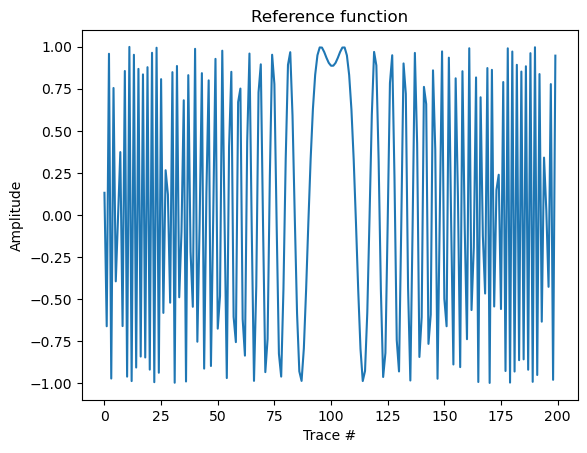

In [4]:
plt.plot(range(n), reffun)
plt.xlabel("Trace #")
plt.ylabel("Amplitude")
plt.title("Reference function")
plt.show()

In [5]:
N = 1000
x = np.linspace(0, 200, N)
irair = np.interp(x, np.arange(n), rair)
irice = np.interp(x, np.arange(n), rice)
# compute theta
itheta = 2 * (irair + ms[0].nu2*irice) / ms[0].c
# compute ref function
ireffun = np.exp(-1j*ss[0].wc*itheta)

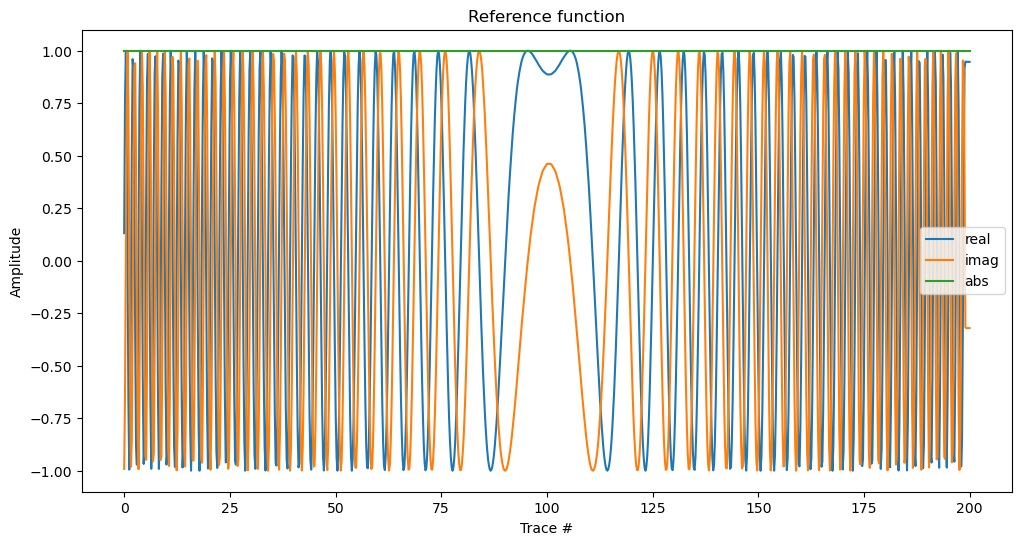

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(x, np.real(ireffun), label="real")
ax.plot(x, np.imag(ireffun), label="imag")
ax.plot(x, np.abs(ireffun), label="abs")
ax.set_xlabel("Trace #")
ax.set_ylabel("Amplitude")
ax.set_title("Reference function")
ax.legend()
plt.show()

## Load radargram to focus

In [7]:
rdrgrm = np.load("../rdrgrm.npy")

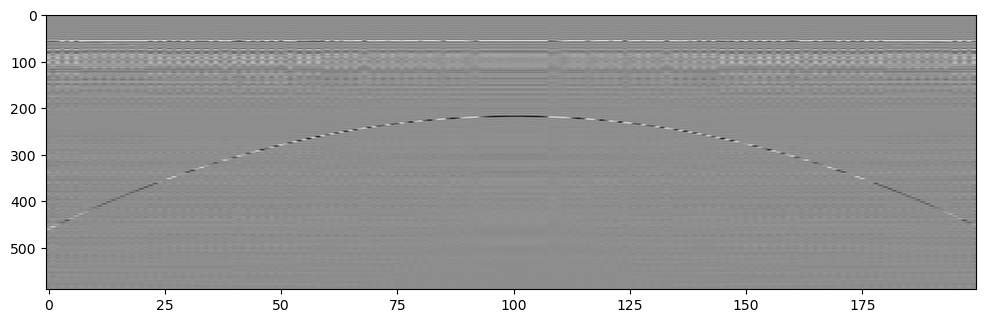

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(np.real(rdrgrm), cmap="grey", aspect=0.1)
plt.show()

## Range Compress

## 1D Focusing

In [9]:
def focus1d(rdr, l1d, dx, dt, reffun):
    focused = np.copy(rdrgrm)
    reffun_conj = np.conjugate(reffun)
    st, en = 0, rdr.shape[0]
    for ti in np.arange(st, en).astype(int):
        print(f"1D Focusing row: {ti+1}/{en}", end="    \r")
        for i, x in enumerate(np.arange(-1*l1d/2, l1d/2, dx)):
            focused[ti, i] = reffun_conj[i]*rdr[ti, i]*dx
    return focused

In [10]:
en = 10000
dx = en / n
focused1d = focus1d(rdrgrm, 10000, dx, 1e-9, reffun)

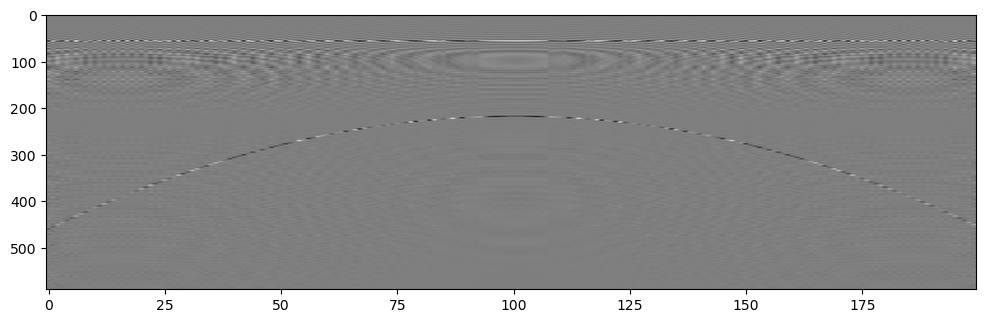

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(np.real(focused1d), cmap="grey", aspect=0.1)
plt.show()

## 2D Focusing

In [12]:
# start and end of radargram
st = 166.8e-6   # start
en = 175e-6  # end

# time per raypath
pathtimes = np.array([m.raypaths[t].path_time for t, m in zip(trs, ms)])

# delta time of radargram
dt = 1 / (8 * ss[0].f0)

# compute range bin offset
rngbins = (pathtimes - st) // dt
rngbins -= np.min(rngbins)

In [13]:
def focus_pix(rdr, t, T, rngbins, k, dt=dt):

    # sol
    c = 299792458
    
    # compute the range which is within the radargram
    rng = np.arange(len(rngbins)) - (len(rngbins) // 2) + T
    
    # compute the value of the range bins in the image
    rngbins = rngbins[rng >= 0] + t
    
    # crop to the region in the image
    rng = rng[rng >= 0]
    rngbins = rngbins[rng < rdr.shape[1]]
    rng = rng[rng < rdr.shape[1]]
    rng = rng[rngbins < rdr.shape[0]]
    rngbins = rngbins[rngbins < rdr.shape[0]]

    # rangebins to time for exponent calculation
    rngtime = rngbins * dt * c
    exp = np.conjugate(np.exp(2j * k * rngtime))

    return np.sum(rdr[rngbins.astype(int), rng.astype(int)] * exp)

In [14]:
k = (2 * np.pi) / ss[0].lam
focused = np.zeros_like(rdrgrm)
for t in range(rdrgrm.shape[0]):
    print(f"Focusing... {t+1}/{rdrgrm.shape[0]}", end="    \r")
    for T in range(rdrgrm.shape[1]):
        focused[t, T] = focus_pix(rdrgrm, t, T, rngbins, k)

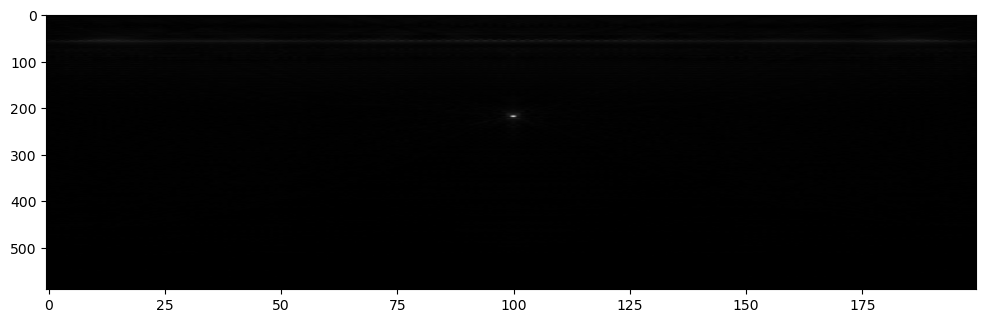

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(np.abs(focused), cmap="grey", aspect=0.1)
plt.show()

In [16]:
points = np.load("../TrackSims/pointtargets.npy")

k = (2 * np.pi) / ss[0].lam
focused_pts = np.zeros_like(points)
for t in range(rdrgrm.shape[0]):
    print(f"Focusing... {t+1}/{points.shape[0]}", end="    \r")
    for T in range(rdrgrm.shape[1]):
        focused_pts[t, T] = focus_pix(points, t, T, rngbins, k)

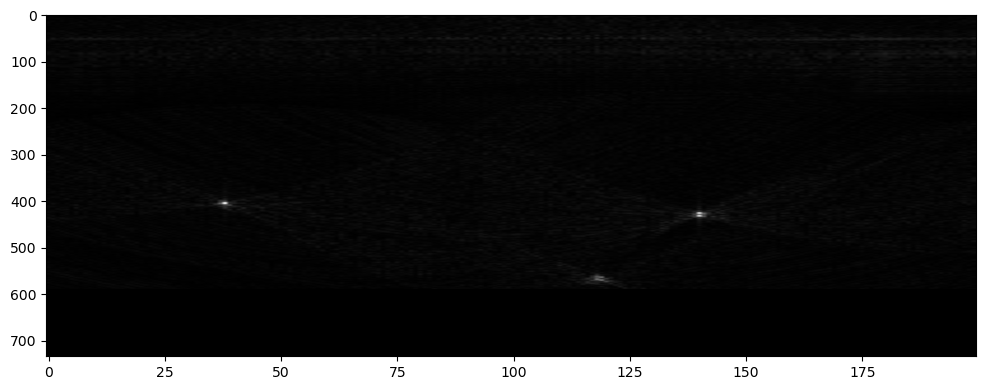

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(np.abs(focused_pts), cmap="grey", aspect=0.1)
plt.show()

In [18]:
points = np.load("../TrackSims/pointtargets10.npy")

k = (2 * np.pi) / (9e6)
focused_pts10 = np.zeros_like(points)
for t in range(points.shape[0]):
    print(f"Focusing... {t+1}/{points.shape[0]}", end="    \r")
    for T in range(points.shape[1]):
        focused_pts10[t, T] = focus_pix(points, t, T, rngbins, k)

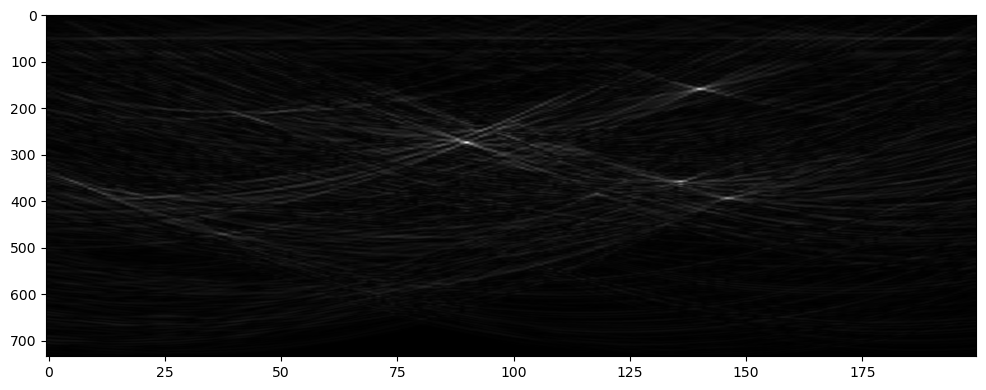

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(np.abs(focused_pts10), cmap="grey", aspect=0.1)
plt.show()